<a href="https://colab.research.google.com/github/w12l3-c/Malaria/blob/main/malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
Models available:
- Pytorch(torchvision, torchtext, torchaudio, torchrec)
  - timm (Image models)
- HuggingFace (models, dataset)
- Kaggle (models, datatset)
- PapersWithCode (Everything)

In [ ]:
! pip install transformers
! pip install torchinfo
! pip install tensorflow-datasets

In [2]:
import torch 
import torchvision
import torchinfo
from torch import nn
from torch import optim
from torchvision import transforms
from torchinfo import summary

import transformers

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import os
import tqdm
import PIL
from PIL import Image

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

device = "cuda" if torch.cuda.is_available() else "cpu"

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3710, done.
remote: Counting objects: 100% (332/332), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 3710 (delta 176), reused 302 (delta 154), pack-reused 3378
Receiving objects: 100% (3710/3710), 648.79 MiB | 28.44 MiB/s, done.
Resolving deltas: 100% (2132/2132), done.
Updating files: 100% (248/248), done.


## Understanding Data

This is a tfds dataset but I will convert it into a pytorch dataset

In [ ]:
tfds.list_builders()

In [3]:
# Using the Malaria Dataset
malaria, info = tfds.load("malaria", split="train", with_info=True, shuffle_files=True)

# or
# train_dataset, test_dataset = tfds.load("malaria", split=["train[:80%]", "train[80%:"], shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteRA7EVB/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Num classes: 2
Class names: ['parasitized', 'uninfected']


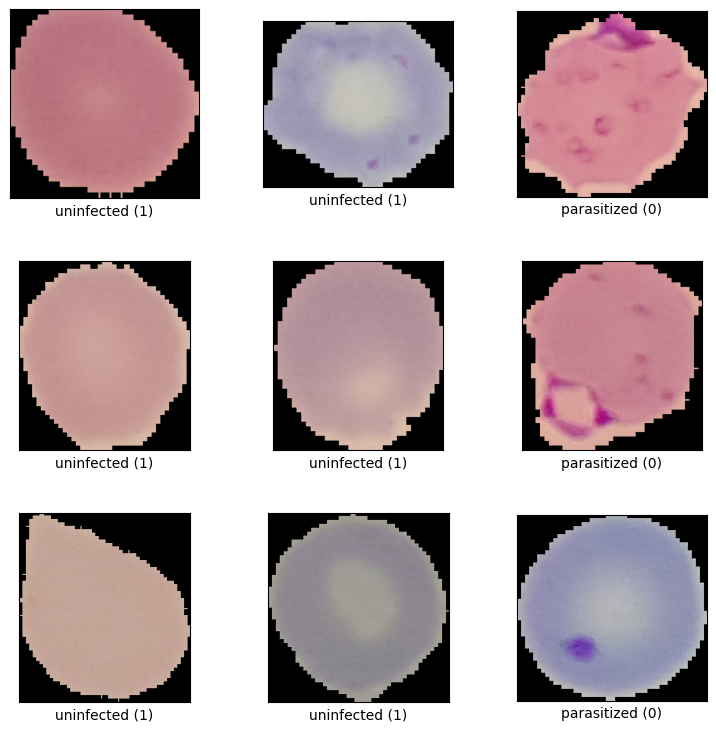

In [12]:
vis = tfds.visualization.show_examples(malaria, info)

In [4]:
# This is an api wrapper so it is equivalent to using a tfds.builder then builder.download_and_prepare() and ds = builder.as_data_source()
# malaria = tfds.data_source('malaria')
builder = tfds.builder('malaria', file_format='array_record')
builder.download_and_prepare()
malaria = builder.as_data_source()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
features = tfds.builder('fashion_mnist').info.features
shape = features['image'].shape
num_classes = features['label'].num_classes

In [6]:
malaria

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
print(info)

In [5]:
train_size = int(0.8 * len(malaria))
test_size = len(malaria) - train_size
train_dataset = malaria.take(train_size)
test_dataset = malaria.skip(train_size)

In [10]:
print(train_dataset)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [29]:
examples = train_dataset.take(1)

for example in examples:
  image, label = example
  print(type(image))
  print(type(label))
  # image = example['image']
  # label = example['label']
  # print(image.shape, label)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [19]:
len(train_dataset)

22046

In [20]:
len(test_dataset)

5512

In [22]:
iter_train = iter(train_dataset)
print(next(iter_train))

{'image': <tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>}


In [23]:
image, label = next(iter_train)['image'], next(iter_train)['label']

In [24]:
# image = np.transpose(image.numpy() / 255, (2, 0, 1))
image_np = torch.from_numpy(np.transpose(image.numpy() / 255, (2, 0, 1))).float()
# image = torch.from_numpy(image.numpy() / 255.0)

In [27]:
print(image.shape)

(103, 103, 3)


In [26]:
print(image_np.shape)

torch.Size([3, 103, 103])


In [42]:
image

<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>

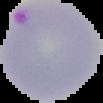

In [44]:
Image.fromarray(image.numpy())

In [66]:
type(image_np)

torch.Tensor

In [ ]:
image_np

In [41]:
iter_train

In [26]:
examples

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [92]:
print(type(label.numpy()))

<class 'numpy.int64'>


In [54]:
label.numpy()

0

In [57]:
count = 0
for i in iter_train:
  image, label = next(iter_train)
  label = label.numpy()
  if label == 1:
    count += 1
print(count)

5563


In [ ]:
malaria_iterable = malaria.as_numpy_iterator()

## Turn into Pytorch Dataset

In [6]:
from keras.utils import image_utils
from torch.utils.data import Dataset

class MalariaDS(Dataset):
  def __init__(self, ds, transform=None):
    self.ds = ds
    self.transform = transform
    self.classes = info.features['label'].names
    self.class2idx = {k:v for k, v in enumerate(self.classes)}

  def __len__(self):
    return len(self.ds)

  def __getitem__(self, idx):
    item = next(iter(self.ds.skip(idx).take(1)))
    image, label = item['image'], item['label'] 
    image = image.numpy() # Convert tf tensor to numpy array
    # image = np.transpose(image.numpy() / 255, (2, 0, 1))  # cast tf into numpy then into torch
    image = Image.fromarray(image) # Transforming need PIL image
    label = label.numpy()

    if self.transform:
      return self.transform(image), label
    else:
      return image, label


In [ ]:
# More optimized enumerator
# https://discuss.pytorch.org/t/enumerate-dataloader-slow/87778/4
class MultiEpochsDataLoader(torch.utils.data.DataLoader):
  def __init__(self, ds, transform, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self._DataLoader__initialized = False
    self.batch_sampler = _RepeatSampler(self.batch_sampler)
    self._DataLoader__initialized = True
    self.iterator = super().__iter__()

    self.ds = ds
    self.transform = transform
    self.classes = info.features['label'].names
    self.class2idx = {k:v for k, v in enumerate(self.classes)}

  def __len__(self):
    return len(self.batch_sampler.sampler)

  def __iter__(self):
    for i in range(len(self)):
      yield next(self.iterator)


class _RepeatSampler(object):
  """ 
  Sampler that repeats forever.

  Args:
    sampler (Sampler)
  """

  def __init__(self, sampler):
    self.sampler = sampler

  def __iter__(self):
    while True:
      yield from iter(self.sampler)

In [7]:
train_transform = torchvision.transforms.Compose([
    # transforms.TrivialAugmentWide(num_magnitude_bins=10),
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
train_ds = MalariaDS(train_dataset, transform=train_transform)
test_ds = MalariaDS(test_dataset, transform=test_transform)

In [106]:
next(iter(train_ds))
# this should get me a tuple of (tensor, int)

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [9]:
# NUM_WORKERS = os.cpu_count()
BATCH = 16
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH, num_workers=0, shuffle=False)

In [10]:
class_names = train_ds.classes

In [109]:
train_loader

In [11]:
print(f"Num of Batches: {len(train_ds)//BATCH + 1}")

Num of Batches: 1378


## Model

It is important that the custom data going into the model is preprocessed same way the original training data that went into the model

In [12]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

In [29]:
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [13]:
# We need to transform the weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

- ResNet
- VGG
- EfficientNet
- ViT
- ConvNeXt
- more in torchvision.models

In [14]:
# Setup the pretrained model
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 73.3MB/s]


In [15]:
summary(model, input_size=(BATCH, 3, 244, 244), 
        col_names=["input_size", "output_size"], #, "num_params", "trainable"], 
        # col_width=5, 
        row_settings=["var_names"])

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                                      Input Shape               Output Shape
EfficientNet (EfficientNet)                                  [16, 3, 244, 244]         [16, 1000]
├─Sequential (features)                                      [16, 3, 244, 244]         [16, 1280, 8, 8]
│    └─Conv2dNormActivation (0)                              [16, 3, 244, 244]         [16, 32, 122, 122]
│    │    └─Conv2d (0)                                       [16, 3, 244, 244]         [16, 32, 122, 122]
│    │    └─BatchNorm2d (1)                                  [16, 32, 122, 122]        [16, 32, 122, 122]
│    │    └─SiLU (2)                                         [16, 32, 122, 122]        [16, 32, 122, 122]
│    └─Sequential (1)                                        [16, 32, 122, 122]        [16, 16, 122, 122]
│    │    └─MBConv (0)                                       [16, 32, 122, 122]        [16, 16, 122, 122]
│    └─Sequential (2)                                        [

In [16]:
# Freeze the layers
for param in model.features.parameters():
  param.requires_grad = False

In [17]:
# Adjust the last layer for our problem
# Which is the Sequential Classifer Part 
# The DropOut can be kept
output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.2, inplace=True),
    torch.nn.Linear(in_features = 1280, 
                    out_features = output_shape, 
                    bias = True)
).to(device)

In [ ]:
summary(model, input_size=(BATCH, 3, 224, 224), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
# Trainable Column: The requires_grad = False means it is Freezed
# Output shape of classifier becomes different, and it is also trainable
# Less training parameter but better accuracy

## Training

In [22]:
# For Debug
for batch, (X, y) in enumerate(train_loader):
  print(f"Batch {batch}, data shape: {X.shape}")
  X = X.to(device)
    
  # Print a few samples from the batch
  if batch > 1:
    break

  for i in range(3):
    image = X[i]
    label = y[i]
    print(f"\tImage shape: {image.shape}, Label: {label}")
    print(model(X))
    print(y)

Batch 0, data shape: torch.Size([16, 3, 224, 224])
	Image shape: torch.Size([3, 224, 224]), Label: 0
tensor([[-0.0890, -0.0101],
        [-0.1120,  0.3578],
        [-0.1019, -0.3797],
        [-0.2086, -0.4744],
        [ 0.1158, -0.1822],
        [-0.1803,  0.3050],
        [ 0.1233, -0.4579],
        [-0.1908, -0.3001],
        [-0.1750, -0.1852],
        [ 0.1459, -0.1063],
        [ 0.0176, -0.2031],
        [-0.1474, -0.0407],
        [-0.2641, -0.2330],
        [ 0.0245, -0.0645],
        [-0.2395,  0.1175],
        [ 0.3742, -0.2633]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0])
	Image shape: torch.Size([3, 224, 224]), Label: 1
tensor([[ 0.0801, -0.2073],
        [-0.2722,  0.2519],
        [-0.0774, -0.2050],
        [-0.0635, -0.3995],
        [-0.1900, -0.1056],
        [ 0.0060,  0.0950],
        [ 0.1659, -0.3197],
        [-0.1588, -0.1118],
        [ 0.0474, -0.2572],
        [ 0.1729,  0.1859],
        [-0.1396, -0

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

train_loss, train_acc = 0, 0
test_loss, test_acc = 0, 0

epochs = 3

for epoch in range(epochs):
  model.train()
  for batch, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.softmax(y_pred, dim=1).argmax(dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  
  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_loader):
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      tloss = loss_fn(test_pred, y)
      test_loss += tloss
      test_pred_class = torch.softmax(test_pred, dim=1).argmax(dim=1)
      test_acc += (test_pred_class == y).sum().item()/len(test_pred)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

  print(f"Epoch {epoch+1}: Train_Acc {train_acc:.4f} | Train_Loss {train_loss:.3f} | Test_Acc {test_acc:.4f} | Test_Loss {test_loss:.3f}")

end_time = time.time()

print(f"Total Training Time: {end_time - start_time:.3f} seconds")

## Evaluate

In [82]:
malaria_path = "/content/malaria cell.PNG"
healthy_path = "/content/healthy cell.PNG"

malaria_image = Image.open(malaria_path)
healthy_image = Image.open(healthy_path)  

malaria_image = malaria_image.resize((224, 224))
healthy_image = healthy_image.resize((224, 224))

# These are png so they are RGBa and i need them to be RGB to normalize the dimensions properly
malaria_image = malaria_image.convert("RGB")
healthy_image = healthy_image.convert("RGB")

In [83]:
malaria_image.mode

'RGB'

In [70]:
malaria_image = torchvision.io.read_image(malaria_path) / 255
healthy_image = torchvision.io.read_image(healthy_path) / 255

In [75]:
eval_transform = torchvision.transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
malaria_image

In [87]:
malaria_imaget = eval_transform(malaria_image)
healthy_imaget = eval_transform(healthy_image)

In [88]:
model.eval()
with torch.inference_mode():
  malaria_imaget = malaria_imaget.unsqueeze(dim=0)
  healthy_imaget = healthy_imaget.unsqueeze(dim=0)

  malaria_pred = model(malaria_imaget.to(device))
  healthy_pred = model(healthy_imaget.to(device))

In [92]:
malaria_label = torch.softmax(malaria_pred, dim=1).argmax(dim=1)
healthy_label = torch.softmax(healthy_pred, dim=1).argmax(dim=1)

In [93]:
malaria_class = class_names[malaria_label]
healthy_class = class_names[healthy_label]

(-0.5, 223.5, 223.5, -0.5)

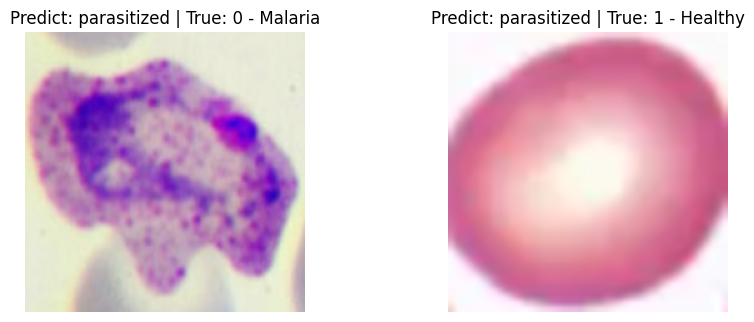

In [98]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(malaria_image)
plt.title(f"Predict: {malaria_class} | True: {0} - Malaria")
plt.axis(False)

plt.subplot(2, 2, 2)
plt.imshow(healthy_image)
plt.title(f"Predict: {healthy_class} | True: {1} - Healthy")
plt.axis(False)

# Tensorflow

In [27]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import scipy
import gc

In [123]:
malaria

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [124]:
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Num classes: 2
Class names: ['parasitized', 'uninfected']


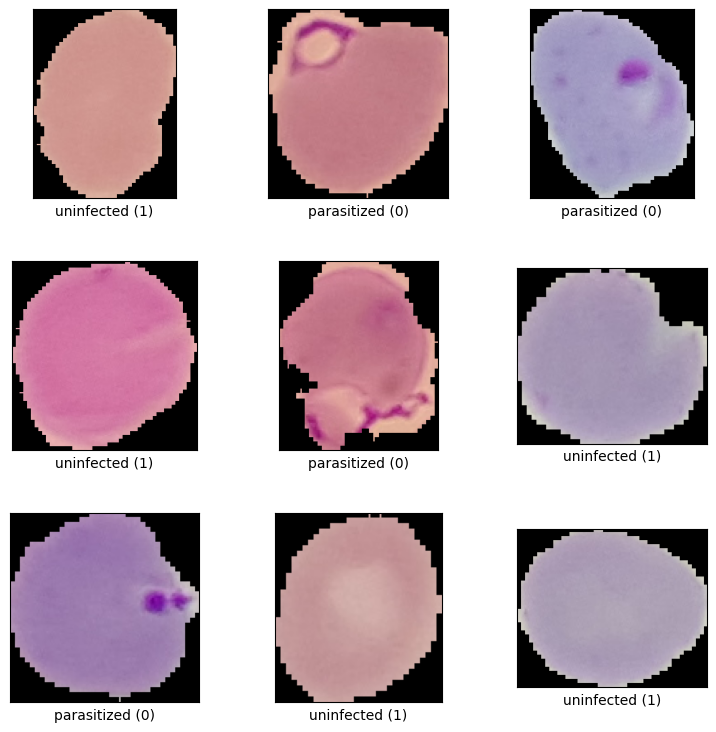

In [126]:
vis = tfds.visualization.show_examples(malaria, info)

In [29]:
train_ds, val_ds, test_ds = tfds.load('malaria', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], shuffle_files=True, as_supervised=True)

In [30]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training images: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating images: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing images: " + str(NUM_TEST_IMAGES))

Num training images: 19291
Num validating images: 4133
Num testing images: 4134


In [31]:
BATCH_SIZE = 16
EPOCHS = 25

In [32]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image, label):
  image, label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 224, 224)
  return image, label

In [33]:
padded_train_ds = (train_ds.cache().map(pad).batch(BATCH_SIZE))
padded_val_ds = (val_ds.cache().map(pad).batch(BATCH_SIZE)) 

In [34]:
image_batch, label_batch = next(iter(padded_train_ds))

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(16):
    ax = plt.subplot(4,4,n+1)
    plt.imshow(image_batch[n])
    if label_batch[n]:
        plt.title("uninfected")
    else:
        plt.title("parasitized")
    plt.axis("off")

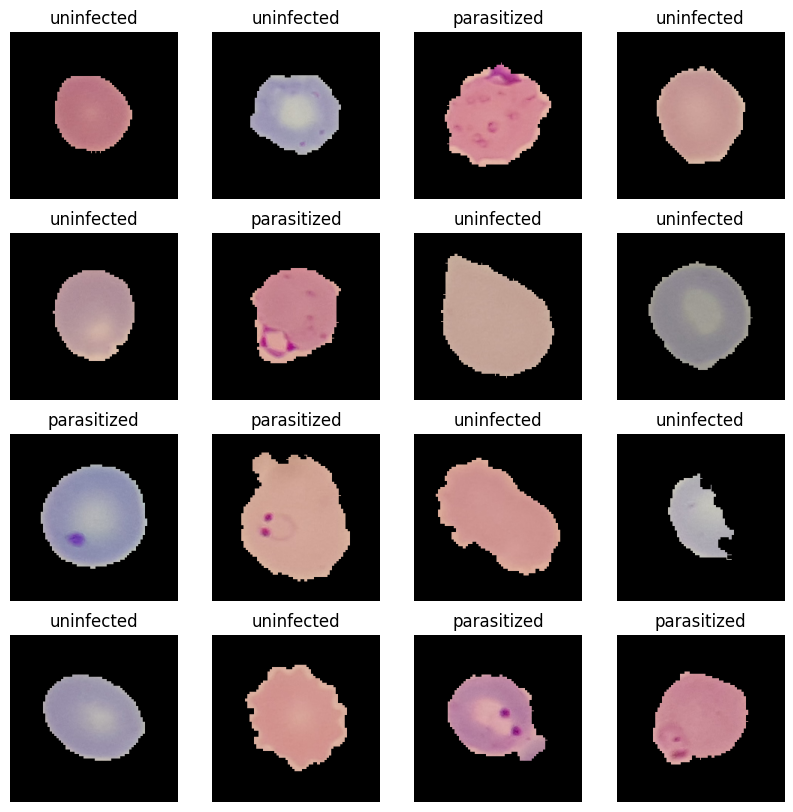

In [142]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [35]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

21834768/21834768 [==============================] - 0s 0us/step


In [36]:
img_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.1),
])

In [37]:
def build_model(classes):
  inputs = tf.keras.layers.Input(shape=(224, 224, 3))
  x = img_augmentation(inputs)
  model = EfficientNetB0(include_top=False, input_tensor=x, weights='imagenet')

  model.trainable = False

  x = tf.keras.layers.GlobalAveragePooling2D()(model.output)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Dropout(0.2)(x)
  if classes > 2:
    outputs = tf.keras.layers.Dense(classes, activation="softmax")(x)
    loss_function = tf.keras.losses.CategoricalCrossentropy()
  else:
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    loss_function = tf.keras.losses.BinaryCrossentropy()

  model = tf.keras.Model(inputs, outputs, name="EfficientNet_Malaria")
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(optimizer, loss=loss_function, metrics=['accuracy'])

  return model

In [38]:
def plot_hist(hist):
  plt.plot(hist.history["accuracy"])
  plt.plot(hist.history["val_accuracy"])
  plt.title("model accuracy")
  plt.ylabel("accuracy")
  plt.xlabel("epoch")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

In [42]:
padded_train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [41]:
padded_val_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model = build_model(2)
hist = model.fit(padded_train_ds, epochs=EPOCHS, validation_data=padded_val_ds, verbose=2)
plot_hist(hist)

# Kaggle

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wallacel","key":"d4846c13171812a348c366972bd73a6b"}'}

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ambarish/breakhis

100% 3.97G/3.99G [00:45<00:00, 125MB/s]
100% 3.99G/3.99G [00:45<00:00, 93.4MB/s]


In [ ]:
! unzip breakhis.zip